In [123]:
import os
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from itertools import product
sns.set_palette('colorblind')
sns.set_color_codes(palette='colorblind')

In [124]:
res_dir = 'results/toy'
scale_dir = 'results/toy/scaled'
model_desc_temp = '{}-lrelu_hsize-100'
data_desc_temp = 'num2-6_input-{}_char_nl-1.7_diff-0-6_trainshapes-[0, 1, 2, 3, 4]_gw6_solarized_100000'
train_desc_temp = 'loss-{}_drop0.5_500eps'
fs = 20
nreps = 4
figsize=(5.5, 4.1)

In [155]:
def get_train_results(nreps, model_desc, data_desc, train_desc):
    
    train_results = []
    for rep in range(nreps):
        print(f'Rep {rep}')
        train_desc_rep = train_desc + f'_rep{rep}'
        # Look in scaled dir first, then normal results
        tr_file = f'{scale_dir}/toy_results_{model_desc}_{data_desc}_{train_desc_rep}.pkl'
        if not os.path.exists(tr_file):
            tr_file = f'{res_dir}/toy_results_{model_desc}_{data_desc}_{train_desc_rep}.pkl'
        try:
            data = pd.read_pickle(tr_file)
#             print(f'Loading {tr_file}')
            data = data[data['dataset'] == 'train']
            data = data.drop(columns=['shape loss', 'rnn iterations'])
            data['repetition'] = rep
            train_results.append(data)
        except FileNotFoundError:
            print(f'Missing {tr_file}')
    tr_data = pd.concat(train_results, ignore_index=True)
    return tr_data

def get_test_results(nreps, model_desc, data_desc, train_desc, pass_count=False):
    shapes_map = {'[0, 1, 2, 3, 4]': 'same as training', '[5, 6, 7, 8, 9]': 'new'}
    lums_map = {'[0.0, 0.5, 1.0]': 'same as training', '[0.1, 0.3, 0.7, 0.9]': 'new'}
    results = []
    for rep in range(nreps):
        print(f'Rep {rep}')
        train_desc_rep = train_desc + f'_rep{rep}'
        # Look in scaled dir first
        te_file = f'{scale_dir}/detailed_test_results_{model_desc}_{data_desc}_{train_desc_rep}.pkl'
        if not os.path.exists(te_file):
            te_file = f'{res_dir}/detailed_test_results_{model_desc}_{data_desc}_{train_desc_rep}.pkl'
#         print(f'Loading {te_file}')
        try:
            data = pd.read_pickle(te_file)
        except FileNotFoundError:
            print(f'Missing {te_file}')
            continue
        if 'test_shapes' in data.columns:
            data = data.drop(columns=['test_shapes', 'train_shapes'])
#         data = data.rename(columns={"test shapes": "Shapes", "test lums": "Luminance"})
        data['Test Shapes'] = data['test shapes'].apply(lambda x: shapes_map[x])
        data['Test Luminance'] = data['test lums'].apply(lambda x: lums_map[x])
        
        if pass_count:
#             data = data[data['Test Shapes'] == 'new']           
#             data = data[data['Test Luminance'] == 'new']
            data = data.rename(columns={'pass count': 'Integration Score'})
            mean_data = data.groupby(['epoch', 'Integration Score', 'Test Shapes', 'Test Luminance', 'repetition']).mean()
        else:
            mean_data = data.groupby(['epoch', 'Test Shapes', 'Test Luminance', 'repetition']).mean()
        results.append(mean_data)
    te_data = pd.concat(results)
    te_data = te_data.reset_index()
    
    newshapes = te_data[te_data['Test Shapes']=='new']
    oldshapes = te_data[te_data['Test Shapes']=='same as training']
    newshapesnewlums = newshapes[newshapes['Test Luminance']=='new']
    newshapesoldlums = newshapes[newshapes['Test Luminance']=='same as training']
    oldshapesnewlums = oldshapes[oldshapes['Test Luminance']=='new']
    oldshapesoldlums = oldshapes[oldshapes['Test Luminance']== 'same as training']
    return oldshapesoldlums, newshapesoldlums, oldshapesnewlums, newshapesnewlums

            
    
def plot_accuracy(tr_results, te_results, ax, legend=True, pass_count=False, loc='lower'):
#     fig, ax = plt.subplots(figsize=figsize)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    tr = sns.lineplot(data=tr_results, x='epoch', y='accuracy', ax=ax, linestyle=':', linewidth=3, color='g', label='training accuracy', errorbar='se', legend=legend)
    if pass_count:
        max_pass = max(te_results['Integration Score'].max(), 6)
        te_results = te_results[te_results['Integration Score'] < max_pass]
        te = sns.lineplot(data=te_results, x='epoch', hue='Integration Score', y='accuracy', ax=ax, errorbar='se', legend=legend)
    else:
        te = sns.lineplot(data=te_results, x='epoch', hue='Test Shapes', style='Test Luminance', ax=ax, y='accuracy', errorbar='se', legend=legend)

    if pass_count and legend:
        h, l = te.get_legend_handles_labels()
        first_legend = ax.legend(handles=[h[0]], loc=loc + ' left')
        ax.add_artist(first_legend)
        ax.legend(handles=h[1:], title='Integration Score', loc=loc + ' right')
    ax.set_ylabel('Accuracy (%)', fontsize=fs)
    ax.set_xlabel('Epoch', fontsize=fs)
    
    ax.set_ylim([10, 101])
    ax.grid()
#     fig.tight_layout()



# Load Data

In [156]:
model_desc = model_desc_temp.format('rnn_classifier2')
data_desc = data_desc_temp.format('shape')
# te_data_desc = data_desc_temp.format('both', '5000')
train_desc = train_desc_temp.format('both')
tr_results_sh = get_train_results(nreps, model_desc, data_desc, train_desc)
oldold_sh, newold_sh, oldnew_sh, newnew_sh = get_test_results(nreps, model_desc, data_desc, train_desc, pass_count=True)

data_desc = data_desc_temp.format('xy')
tr_results_xy = get_train_results(nreps, model_desc, data_desc, train_desc)
oldold_xy, newold_xy, oldnew_xy, newnew_xy = get_test_results(nreps, model_desc, data_desc, train_desc, pass_count=True)

data_desc = data_desc_temp.format('both')
tr_results = get_train_results(nreps, model_desc, data_desc, train_desc)
oldold, newold, oldnew, newnew = get_test_results(nreps, model_desc, data_desc, train_desc, pass_count=True)

Rep 0
Rep 1
Rep 2
Missing results/toy/toy_results_rnn_classifier2-lrelu_hsize-100_num2-6_input-shape_char_nl-1.7_diff-0-6_trainshapes-[0, 1, 2, 3, 4]_gw6_solarized_100000_loss-both_drop0.5_500eps_rep2.pkl
Rep 3
Missing results/toy/toy_results_rnn_classifier2-lrelu_hsize-100_num2-6_input-shape_char_nl-1.7_diff-0-6_trainshapes-[0, 1, 2, 3, 4]_gw6_solarized_100000_loss-both_drop0.5_500eps_rep3.pkl
Rep 0
Rep 1
Rep 2
Missing results/toy/detailed_test_results_rnn_classifier2-lrelu_hsize-100_num2-6_input-shape_char_nl-1.7_diff-0-6_trainshapes-[0, 1, 2, 3, 4]_gw6_solarized_100000_loss-both_drop0.5_500eps_rep2.pkl
Rep 3
Missing results/toy/detailed_test_results_rnn_classifier2-lrelu_hsize-100_num2-6_input-shape_char_nl-1.7_diff-0-6_trainshapes-[0, 1, 2, 3, 4]_gw6_solarized_100000_loss-both_drop0.5_500eps_rep3.pkl
Rep 0
Rep 1
Rep 2
Missing results/toy/toy_results_rnn_classifier2-lrelu_hsize-100_num2-6_input-xy_char_nl-1.7_diff-0-6_trainshapes-[0, 1, 2, 3, 4]_gw6_solarized_100000_loss-both_drop0.

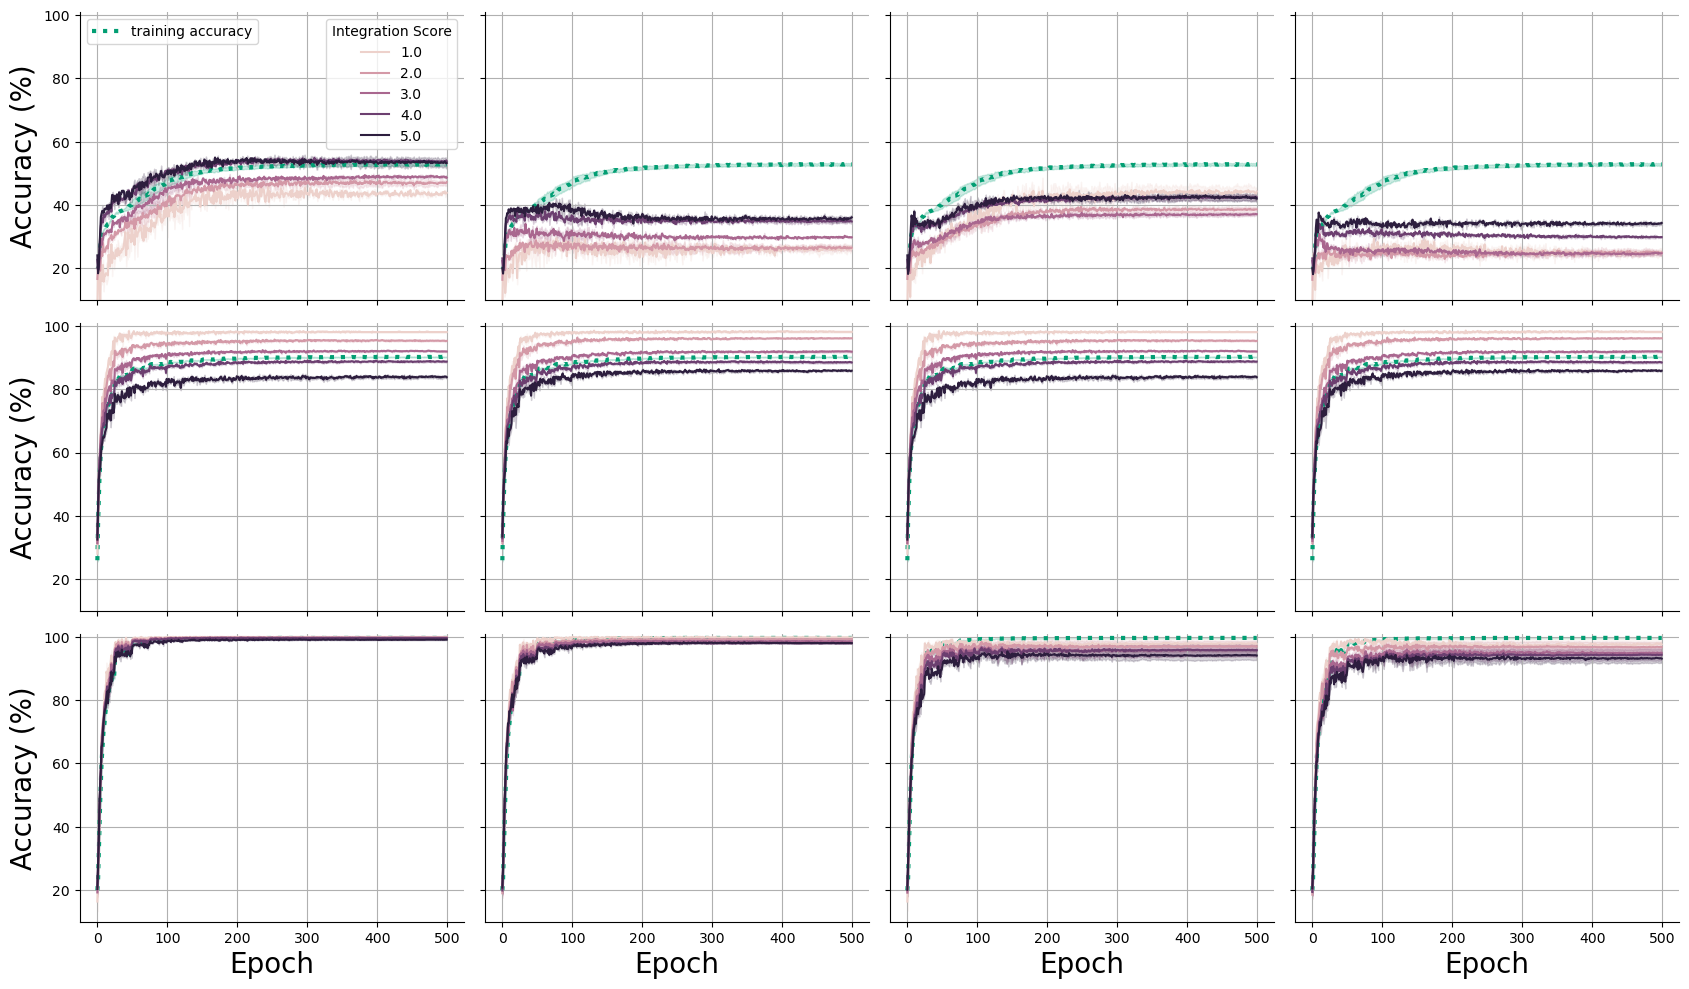

In [157]:
fig, axs = plt.subplots(3, 4, figsize=(17,10), sharex=True, sharey=True)
plot_accuracy(tr_results_sh, oldold_sh, ax=axs[0,0], legend=True, pass_count=True, loc='upper')
plot_accuracy(tr_results_sh, newold_sh, ax=axs[0,1], legend=False, pass_count=True)
plot_accuracy(tr_results_sh, oldnew_sh, ax=axs[0,2], legend=False, pass_count=True)
plot_accuracy(tr_results_sh, newnew_sh, ax=axs[0,3], legend=False, pass_count=True)

plot_accuracy(tr_results_xy, oldold_xy, ax=axs[1,0], legend=False, pass_count=True)
plot_accuracy(tr_results_xy, newold_xy, ax=axs[1,1], legend=False, pass_count=True)
plot_accuracy(tr_results_xy, oldnew_xy, ax=axs[1,2], legend=False, pass_count=True)
plot_accuracy(tr_results_xy, newnew_xy, ax=axs[1,3], legend=False, pass_count=True)

plot_accuracy(tr_results, oldold, ax=axs[2,0], legend=False, pass_count=True)
plot_accuracy(tr_results, newold, ax=axs[2,1], legend=False, pass_count=True)
plot_accuracy(tr_results, oldnew, ax=axs[2,2], legend=False, pass_count=True)
plot_accuracy(tr_results, newnew, ax=axs[2,3], legend=False, pass_count=True)
fig.tight_layout()
plt.savefig('figures/workshop/distinctive.pdf', dpi=300)

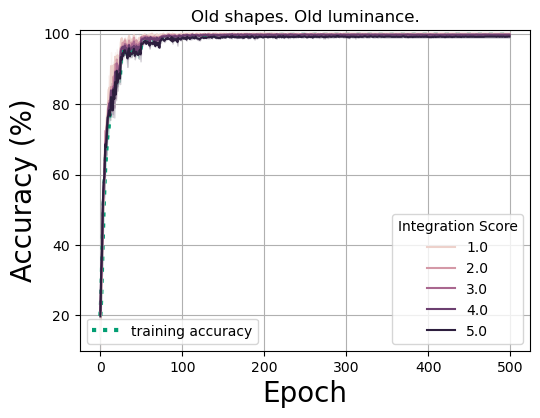

In [128]:
plot_accuracy(tr_results, oldshapesoldlums, legend=True, pass_count=True, loc='lower')
plt.title('Old shapes. Old luminance.')
plt.savefig('figures/workshop/distinctive_both_oldold.pdf')

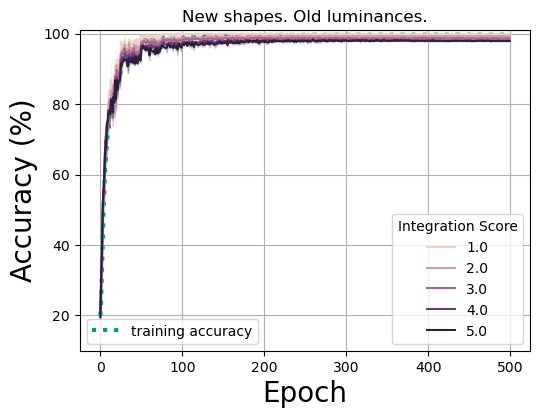

In [129]:
plot_accuracy(tr_results, newshapesoldlums, legend=True, pass_count=True, loc='lower')
plt.title('New shapes. Old luminances.')
plt.savefig('figures/workshop/distinctive_both_newold.pdf')

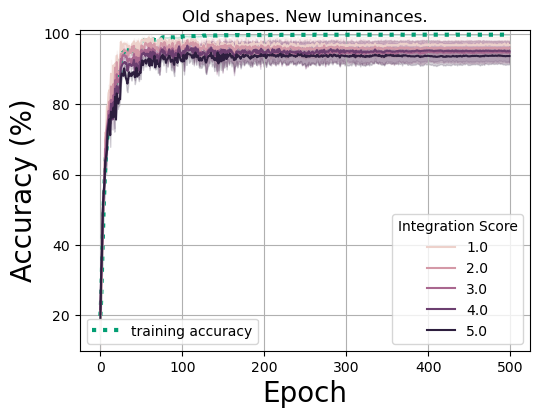

In [130]:
plot_accuracy(tr_results, oldshapesnewlums, legend=True, pass_count=True, loc='lower')
plt.title('Old shapes. New luminances.')
plt.savefig('figures/workshop/distinctive_both_oldnew.pdf')

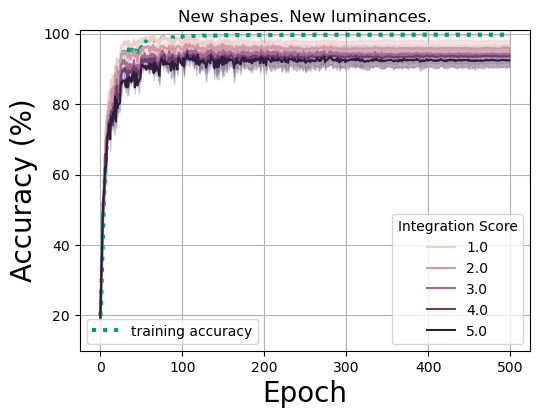

In [131]:
plot_accuracy(tr_results, newshapesnewlums, legend=True, pass_count=True, loc='lower')
plt.title('New shapes. New luminances.')
plt.savefig('figures/workshop/distinctive_both_newnew.pdf')

# Just pixels

In [132]:
model_desc = model_desc_temp.format('rnn_classifier2')
data_desc = data_desc_temp.format('shape')
# te_data_desc = data_desc_temp.format('both', '5000')
train_desc = train_desc_temp.format('both')

In [133]:
tr_results = get_train_results(nreps, model_desc, data_desc, train_desc)
oldshapesoldlums, newshapesoldlums, oldshapesnewlums, newshapesnewlums = get_test_results(nreps, model_desc, data_desc, train_desc, pass_count=True)

Rep 0
Rep 1
Rep 2
Missing results/toy/toy_results_rnn_classifier2-lrelu_hsize-100_num2-6_input-shape_char_nl-1.7_diff-0-6_trainshapes-[0, 1, 2, 3, 4]_gw6_solarized_100000_loss-both_drop0.5_500eps_rep2.pkl
Rep 3
Missing results/toy/toy_results_rnn_classifier2-lrelu_hsize-100_num2-6_input-shape_char_nl-1.7_diff-0-6_trainshapes-[0, 1, 2, 3, 4]_gw6_solarized_100000_loss-both_drop0.5_500eps_rep3.pkl
Rep 0
Rep 1
Rep 2
Missing results/toy/detailed_test_results_rnn_classifier2-lrelu_hsize-100_num2-6_input-shape_char_nl-1.7_diff-0-6_trainshapes-[0, 1, 2, 3, 4]_gw6_solarized_100000_loss-both_drop0.5_500eps_rep2.pkl
Rep 3
Missing results/toy/detailed_test_results_rnn_classifier2-lrelu_hsize-100_num2-6_input-shape_char_nl-1.7_diff-0-6_trainshapes-[0, 1, 2, 3, 4]_gw6_solarized_100000_loss-both_drop0.5_500eps_rep3.pkl


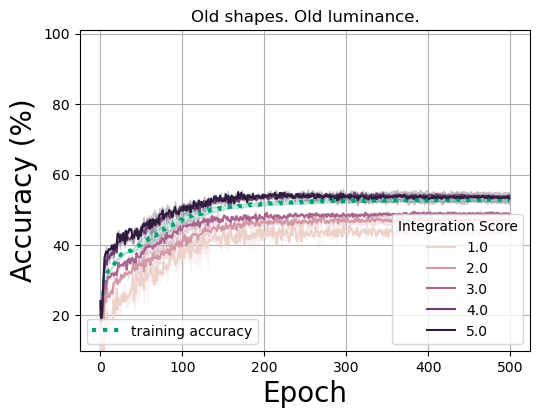

In [134]:
plot_accuracy(tr_results, oldshapesoldlums, legend=True, pass_count=True, loc='lower')
plt.title('Old shapes. Old luminance.')
plt.savefig('figures/workshop/distinctive_pix_oldold.pdf')

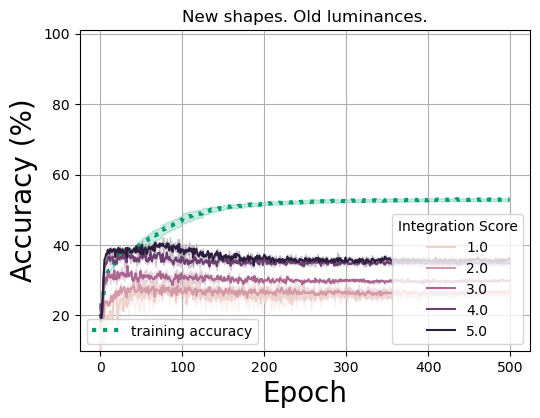

In [135]:
plot_accuracy(tr_results, newshapesoldlums, legend=True, pass_count=True, loc='lower')
plt.title('New shapes. Old luminances.')
plt.savefig('figures/workshop/distinctive_pix_newold.pdf')

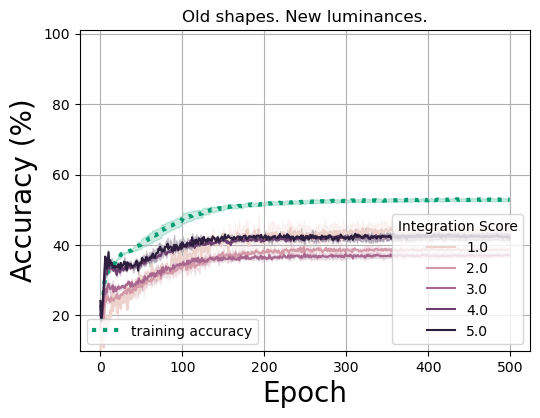

In [136]:
plot_accuracy(tr_results, oldshapesnewlums, legend=True, pass_count=True, loc='lower')
plt.title('Old shapes. New luminances.')
plt.savefig('figures/workshop/distinctive_pix_oldnew.pdf')

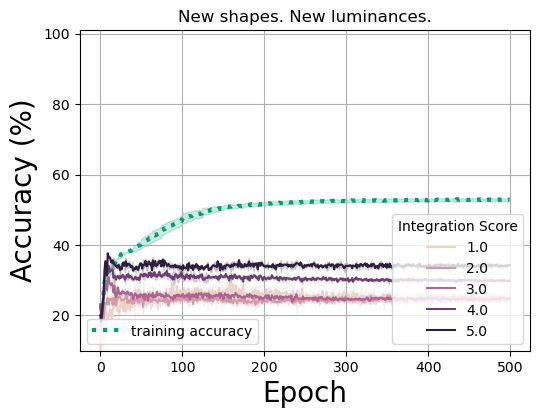

In [137]:
plot_accuracy(tr_results, newshapesnewlums, legend=True, pass_count=True, loc='lower')
plt.title('New shapes. New luminances.')
plt.savefig('figures/workshop/distinctive_pix_newnew.pdf')

# Coordinates only

In [138]:
model_desc = model_desc_temp.format('rnn_classifier2')
data_desc = data_desc_temp.format('xy')
# te_data_desc = data_desc_temp.format('both', '5000')
train_desc = train_desc_temp.format('both')

In [139]:
tr_results = get_train_results(nreps, model_desc, data_desc, train_desc)
oldshapesoldlums, newshapesoldlums, oldshapesnewlums, newshapesnewlums = get_test_results(nreps, model_desc, data_desc, train_desc, pass_count=True)

Rep 0
Rep 1
Rep 2
Missing results/toy/toy_results_rnn_classifier2-lrelu_hsize-100_num2-6_input-xy_char_nl-1.7_diff-0-6_trainshapes-[0, 1, 2, 3, 4]_gw6_solarized_100000_loss-both_drop0.5_500eps_rep2.pkl
Rep 3
Missing results/toy/toy_results_rnn_classifier2-lrelu_hsize-100_num2-6_input-xy_char_nl-1.7_diff-0-6_trainshapes-[0, 1, 2, 3, 4]_gw6_solarized_100000_loss-both_drop0.5_500eps_rep3.pkl
Rep 0
Rep 1
Rep 2
Missing results/toy/detailed_test_results_rnn_classifier2-lrelu_hsize-100_num2-6_input-xy_char_nl-1.7_diff-0-6_trainshapes-[0, 1, 2, 3, 4]_gw6_solarized_100000_loss-both_drop0.5_500eps_rep2.pkl
Rep 3
Missing results/toy/detailed_test_results_rnn_classifier2-lrelu_hsize-100_num2-6_input-xy_char_nl-1.7_diff-0-6_trainshapes-[0, 1, 2, 3, 4]_gw6_solarized_100000_loss-both_drop0.5_500eps_rep3.pkl


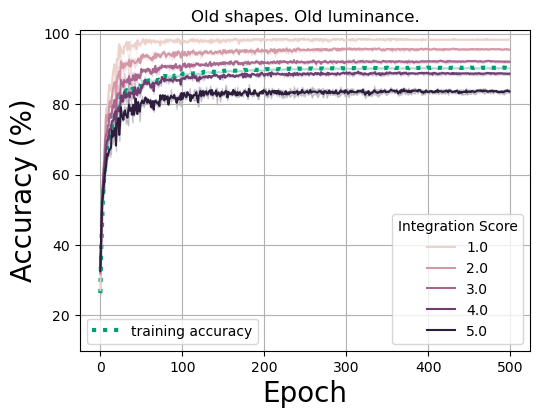

In [140]:
plot_accuracy(tr_results, oldshapesoldlums, legend=True, pass_count=True, loc='lower')
plt.title('Old shapes. Old luminance.')
plt.savefig('figures/workshop/distinctive_xy_oldold.pdf')

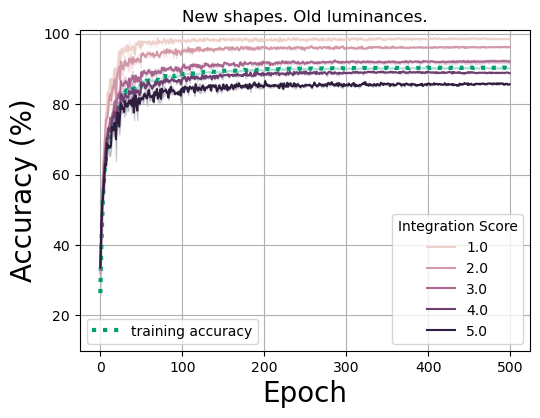

In [141]:
plot_accuracy(tr_results, newshapesoldlums, legend=True, pass_count=True, loc='lower')
plt.title('New shapes. Old luminances.')
plt.savefig('figures/workshop/distinctive_xy_newold.pdf')

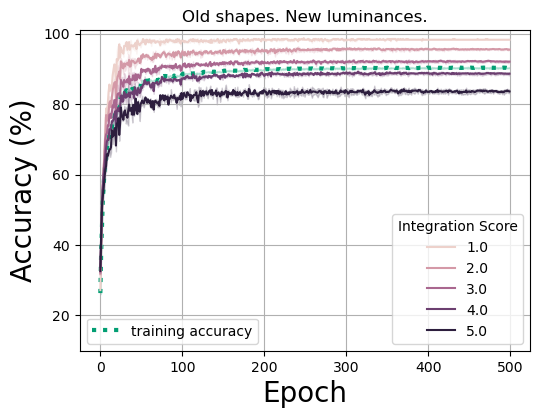

In [142]:
plot_accuracy(tr_results, oldshapesnewlums, legend=True, pass_count=True, loc='lower')
plt.title('Old shapes. New luminances.')
plt.savefig('figures/workshop/distinctive_xy_oldnew.pdf')

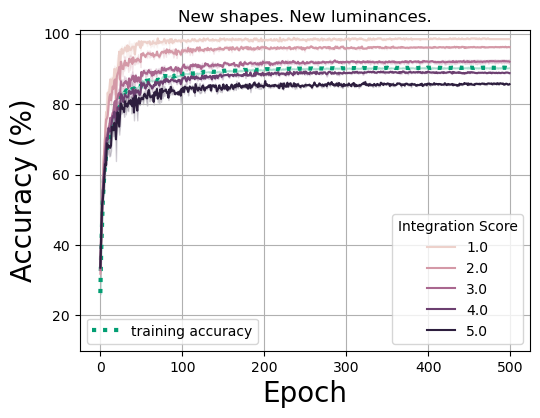

In [143]:
plot_accuracy(tr_results, newshapesnewlums, legend=True, pass_count=True, loc='lower')
plt.title('New shapes. New luminances.')
plt.savefig('figures/workshop/distinctive_xy_newnew.pdf')